## Question 2 Optimization

In [11]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import string
import os

import torch
import torchvision # Use built-in data 
from torchvision import transforms, datasets
import torch.nn as nn # contain trainable parameters
import torch.nn.functional as F #  purely functional.
import torch.nn.init as init
import torch.optim as optim
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



In [182]:
n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 500 # print the performance (loss) per 500 batches

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

device = torch.device("cuda")

In [183]:
compose_func = [transforms.ToTensor(),
                transforms.Normalize((0.1307,),(0.3081,))]

train = datasets.MNIST("./data", train=True, download=True, 
                       transform=transforms.Compose(compose_func)) # transform data to tensor
test = datasets.MNIST("./data", train=False, download=True,
                     transform=transforms.Compose(compose_func))

In [184]:
# batch data. If pass all data at once, machine is hard to learn the "general rules"
# batch_size: usually 8-64 depending on the comuting ability
# shuffle: should be True. Again, for the machine to learn the general rules instead of 
# 0 first and then 1
trainset = torch.utils.data.DataLoader(train, batch_size=batch_size_train, shuffle=True) # load and train data
testset = torch.utils.data.DataLoader(test, batch_size=batch_size_test, shuffle=True) 

In [ ]:
## https://www.kaggle.com/akhileshrai/intro-cnn-pytorch-pca-tnse-isomap/data?select=test.csv
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
# https://gist.github.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5
def init_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                init.normal_(m.bias.data)
        elif isinstance(m, nn.BatchNorm2d):
            init.normal_(m.weight.data, mean=1, std=0.02)
            init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            init.xavier_normal_(m.weight.data)
            init.normal_(m.bias.data)

In [188]:
def train(trainset, model, optimizer, epoch, 
          train_iter_losses, epoch_ls, train_gradient_norm, accu,
           layer_weights_flattened, weights_flattened): # get accuracy, loss, gradient norm

    running_loss = 0.0
    total = 0.0
    correct = 0
    for batch_idx, (data, target) in enumerate(trainset):
        data = data.to(device)
        target = target.to(device)

        
        # forward pass
        output = model(data) #The outputs are energies for the 10 classes.
        ls = criterion(output, target)
        
        # metrics 
        train_iter_losses.append(ls.item())
        running_loss += ls.item()
        
        #_, original = torch.max(target, 1) # works for one-hot-encoding 
        original = target
        _, predicted =  torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted==original).sum().item()
        
        # grad norm
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                temp = p.grad.data
                grad = (temp.cpu().numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all**0.5
        train_gradient_norm.append(grad_norm)
        
        # backward pass
        optimizer.zero_grad() #Set the gradients to zero
        ls.backward()
        optimizer.step()# adjust the weights for us
        
    accu.append(correct/total)
    epoch_ls.append(running_loss/len(trainset))
    print("Epoch: ", epoch,"\tAccuracy: ", correct/total, "\tLoss: ", running_loss/len(trainset))
    
    # get flattend weights of fc2  
    m_weights = model.layer2[0].weight.reshape(1,-1)
    layer_weights_flattened.append(m_weights.detach().cpu().numpy())
    
    # get flattened model weights 
    all_param = torch.tensor([]).to(device)
    for param in model.parameters():
        all_param = torch.cat((all_param,param.reshape(1,-1).squeeze()),dim=0)
    weights_flattened.append(all_param.detach().cpu().numpy())


### 2-1 Visualize the optimization process.
Requirements:
* Collect weights of the model every n epochs. 
* Also collect the weights of the model of different training events.(Collect the weights every 3 epochs, and train 8 times. Reduce the dimension of  weights to 2 by PCA.)
* Record the accuracy (loss) corresponding to the collected parameters.
* Plot the above results on a figure.

**Report:**
* Describe your experiment settings. (The cycle you record the model parameters, optimizer, dimension reduction method, etc) 
* Train the model for 8 times, selecting the parameters of any one layer and whole model and plot them on the figures separately.
* Comment on your result.




In [9]:
m1 = ConvNet().to(device)
m1.apply(init_weights)
optimizer = SGD(m1.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_iter_losses = [] 
train_epoch_lossess = []
train_gradient_norm = []
train_accu = []
layer_weights_flattened = []
weights_flattened = []

n_epochs = 80
for epoch in range(1, n_epochs + 1):
  train(trainset, m1, optimizer, epoch, 
          train_iter_losses, train_epoch_lossess, train_gradient_norm, train_accu,
           layer_weights_flattened, weights_flattened)

# layer weights 
layerw_df = pd.DataFrame(np.concatenate(layer_weights_flattened))

# model weights 
model_weights = []
for ary in weights_flattened:
    model_weights.append(ary.reshape(-1, len(ary)))

modelw_df = pd.DataFrame(np.concatenate(model_weights))

Epoch:  1 	Accuracy:  0.9526166666666667 	Loss:  0.16626779677501238
Epoch:  2 	Accuracy:  0.9815666666666667 	Loss:  0.06233659519432688
Epoch:  3 	Accuracy:  0.9857 	Loss:  0.0465658573281846
Epoch:  4 	Accuracy:  0.9884833333333334 	Loss:  0.03902583254942063
Epoch:  5 	Accuracy:  0.9902833333333333 	Loss:  0.033282210665153286
Epoch:  6 	Accuracy:  0.9915833333333334 	Loss:  0.029006056882975213
Epoch:  7 	Accuracy:  0.9923 	Loss:  0.026252456888211952
Epoch:  8 	Accuracy:  0.9933666666666666 	Loss:  0.023413350484070818
Epoch:  9 	Accuracy:  0.99385 	Loss:  0.021089228637417707
Epoch:  10 	Accuracy:  0.99485 	Loss:  0.018923372727819285
Epoch:  11 	Accuracy:  0.9953166666666666 	Loss:  0.01745324903865283
Epoch:  12 	Accuracy:  0.99585 	Loss:  0.015868603027855623
Epoch:  13 	Accuracy:  0.9962833333333333 	Loss:  0.014386105551774095
Epoch:  14 	Accuracy:  0.9968833333333333 	Loss:  0.013202493339141549
Epoch:  15 	Accuracy:  0.9970666666666667 	Loss:  0.012285595515283442
Epoch: 

In [10]:
layerwei_x = layerw_df
layerwei_y = pd.DataFrame({0:[1]*(len(layerw_df.index))})
modelwei_x = modelw_df
modelwei_y = pd.DataFrame({0:[1]*(len(modelw_df.index))})

In [11]:
# Train the model 8 times 
for n in range(1,9):
    print("Train #",n)
    m1 = ConvNet().to(device)
    m1.apply(init_weights)
    optimizer = SGD(m1.parameters(), lr=learning_rate, momentum=momentum)
    criterion = nn.CrossEntropyLoss()

    train_iter_losses = [] 
    train_epoch_lossess = []
    train_gradient_norm = []
    train_accu = []
    layer_weights_flattened = []
    weights_flattened = []
    
    n_epochs = 82
    for epoch in range(1, n_epochs + 1):
      train(trainset, m1, optimizer, epoch, 
              train_iter_losses, train_epoch_lossess, train_gradient_norm, train_accu,
               layer_weights_flattened, weights_flattened)

    # layer weights 
    layerw_df = pd.DataFrame(np.concatenate(layer_weights_flattened))
    layerw_df = layerw_df.iloc[[i for i in range(0,82) if i%3==0],:]
    layerw_y = pd.DataFrame({n:[n]*(len(layerw_df.index))})

    # model weights 
    model_weights = []
    for ary in weights_flattened:
        model_weights.append(ary.reshape(-1, len(ary)))

    modelw_df = pd.DataFrame(np.concatenate(model_weights))
    modelw_df = modelw_df.iloc[[i for i in range(0,82) if i%3==0],:]
    modelw_y = pd.DataFrame({n:[n]*(len(modelw_df.index))})
    
    layerwei_x = layerwei_x.append(layerw_df)
    layerwei_y = layerwei_y.append(layerw_y)
    modelwei_x = modelwei_x.append(modelw_df)
    modelwei_y = modelwei_y.append(modelw_df)
    

Train # 1
Epoch:  1 	Accuracy:  0.9547833333333333 	Loss:  0.15604894832054625
Epoch:  2 	Accuracy:  0.9822 	Loss:  0.06045810178940945
Epoch:  3 	Accuracy:  0.9864 	Loss:  0.04693739302704599
Epoch:  4 	Accuracy:  0.98865 	Loss:  0.038153537416901154
Epoch:  5 	Accuracy:  0.9902333333333333 	Loss:  0.03305658949405026
Epoch:  6 	Accuracy:  0.9914 	Loss:  0.029512941856051425
Epoch:  7 	Accuracy:  0.9924333333333333 	Loss:  0.02597762993809932
Epoch:  8 	Accuracy:  0.9932 	Loss:  0.02342414687452679
Epoch:  9 	Accuracy:  0.9940833333333333 	Loss:  0.0213059485069417
Epoch:  10 	Accuracy:  0.9946333333333334 	Loss:  0.01920493408822383
Epoch:  11 	Accuracy:  0.99535 	Loss:  0.017309937548275336
Epoch:  12 	Accuracy:  0.99585 	Loss:  0.016022856057000243
Epoch:  13 	Accuracy:  0.9964833333333334 	Loss:  0.014123484416501667
Epoch:  14 	Accuracy:  0.9969833333333333 	Loss:  0.013219960253320333
Epoch:  15 	Accuracy:  0.99725 	Loss:  0.012041963075804187
Epoch:  16 	Accuracy:  0.9977166666

In [13]:
# save parameters to disk 
import os 
# tempdir = os.path.join('./','model_x.csv')
# modelwei_x.to_csv(tempdir,header=True,index=False)

# tempdir = os.path.join('./','model_y.csv')
# modelwei_x.to_csv(tempdir,header=True,index=False) #typo 

# tempdir = os.path.join('./','layer_x.csv')
# layerwei_x.to_csv(tempdir,header=True,index=False)

# tempdir = os.path.join('./','layer_y.csv')
# layerwei_y.to_csv(tempdir,header=True,index=False)



In [100]:
# correct modelwei_y and wei_x (remove the first 80 rows)
layerwei_y.reset_index(drop=True,inplace=True)
layerwei_y.drop(layerwei_y.index[0:81],inplace=True)

modelwei_y = layerwei_y

layerwei_x.reset_index(drop=True,inplace=True)
layerwei_x.drop(layerwei_x.index[0:81],inplace=True)

modelwei_x.reset_index(drop=True,inplace=True)
modelwei_x.drop(modelwei_x.index[0:81],inplace=True)

PCA

In [ ]:
# make a new label column using wei_y
tempseries = layerwei_y[1].dropna()
for i in range(2,9):
    tempseries = tempseries.append(layerwei_y[i].dropna())
wei_y = pd.DataFrame({"label":tempseries}).reset_index(drop=True)

In [137]:
# layer weights 
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(layerwei_x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, wei_y], axis = 1)

,principal component 1,principal component 2
0,-0.782350,-2.008872
1,-0.825267,-2.123755
2,-0.849625,-2.195639
3,-0.864034,-2.243005
4,-0.875447,-2.279707
...,...,...
219,2.229893,0.275883
220,2.229694,0.275846
221,2.228838,0.276214
222,2.227754,0.276479


In [ ]:
# PCA plot of layer weights
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
fig.title = "te"
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
colors = ['r', 'g', 'b','grey','b','b','b','b']
for target in targets:
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']       
               , s = 50)
ax.legend(["model"+str(i) for i in targets])
ax.grid()

plt.savefig("./Figures/2-1 PCA.png",transparent=False)
fig.show()

In [19]:
# model weights 
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(modelwei_x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, wei_y], axis = 1)

In [28]:
finalDf

,principal component 1,principal component 2,label
0,1.659107,-5.264049,1.0
1,1.719090,-5.518615,1.0
2,1.752959,-5.658724,1.0
3,1.779805,-5.763448,1.0
4,1.804227,-5.846211,1.0
...,...,...,...
219,-0.598429,6.957216,8.0
220,-0.599539,6.964880,8.0
221,-0.600417,6.971873,8.0
222,-0.601016,6.978516,8.0


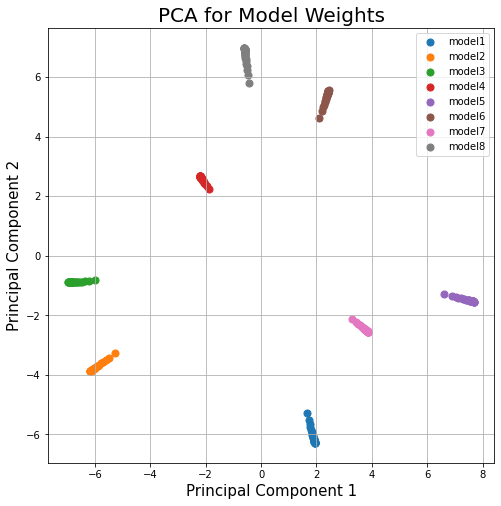

In [39]:
# PCA plot of model weights
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_title('PCA for Model Weights', fontsize = 20)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)

targets=[i for i in range(1,9)]
for target in targets:
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']       
               , s = 50)
ax.legend(["model"+str(i) for i in targets])
ax.grid()

plt.savefig("./Figures/2-1 PCA for model weights.png",transparent=False)
fig.show()

### 2-2 Observe gradient norm during training.
Requirements:
* Record the gradient norm and the loss during training.
* Plot them on one figure.

**Report**
* Plot one figure which contain gradient norm to iterations and the loss to iterations. 
* Comment your result. 


In [189]:
m2 = ConvNet().to(device)
m2.apply(init_weights)
optimizer = SGD(m2.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_iter_losses2 = [] 
train_gradient_norm = []

n_epochs = 10
for epoch in range(1, n_epochs + 1):
    train(trainset, m2, optimizer, epoch, 
          train_iter_losses2, [], train_gradient_norm, [],
           [], [])

Epoch:  1 	Accuracy:  0.9555166666666667 	Loss:  0.16246067138233863
Epoch:  2 	Accuracy:  0.9819 	Loss:  0.06162502256178382
Epoch:  3 	Accuracy:  0.9864166666666667 	Loss:  0.04764316561468033
Epoch:  4 	Accuracy:  0.9880166666666667 	Loss:  0.040243244478364845
Epoch:  5 	Accuracy:  0.9896666666666667 	Loss:  0.034528441358554256
Epoch:  6 	Accuracy:  0.9911666666666666 	Loss:  0.029766130487251876
Epoch:  7 	Accuracy:  0.9919 	Loss:  0.02703882334766282
Epoch:  8 	Accuracy:  0.9928833333333333 	Loss:  0.024542250570211647
Epoch:  9 	Accuracy:  0.9936333333333334 	Loss:  0.022009403505826742
Epoch:  10 	Accuracy:  0.9945 	Loss:  0.01975933220745104


Loss vs grad norm

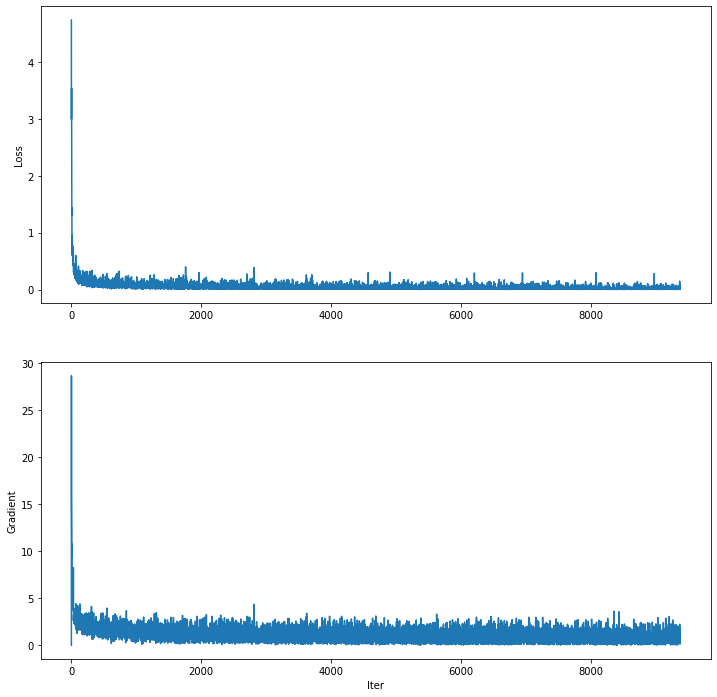

In [224]:
fig, axs = plt.subplots(2,figsize=(12,12))
axs[0].plot(train_iter_losses2)
axs[0].set(ylabel='Loss')

axs[1].plot(train_gradient_norm)
axs[1].set(ylabel='Gradient')

axs[1].set(xlabel="Iter")

plt.savefig("./Figures/2-2 grad vs loss1.png",transparent=False)

From epoch \#2 on 

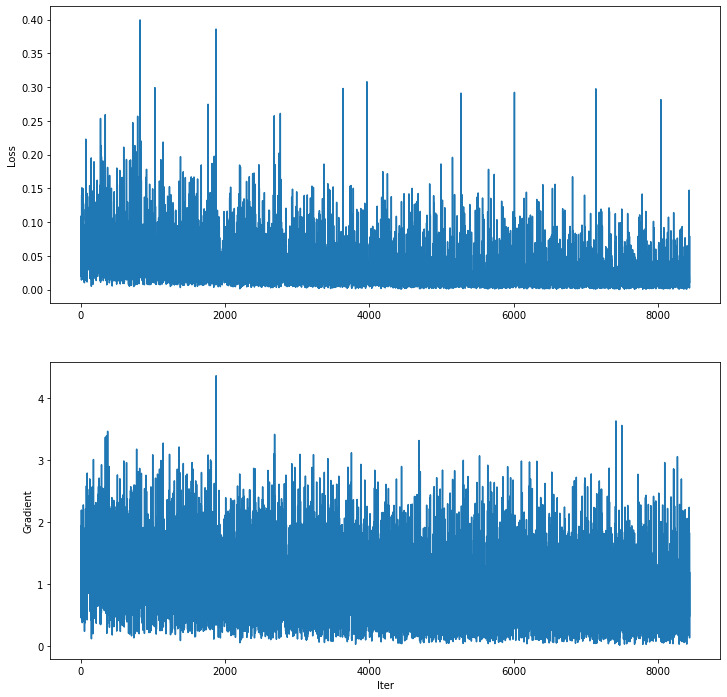

In [226]:
fig, axs = plt.subplots(2,figsize=(12,12))
axs[0].plot(lo2)
axs[0].set(ylabel='Loss')

axs[1].plot(gr2)
axs[1].set(ylabel='Gradient')

axs[1].set(xlabel="Iter")

plt.savefig("./Figures/2-2 grad vs loss2.png",transparent=False)

### 2-3 What happens when gradient is almost zero?
Requirements
* Try to find the weights of the model when the gradient norm is zero (as small as possible).
* Compute the "minimal ratio" of the weights: how likely the weights to be a minima.
* Plot the figure between minimal ratio and the loss when the gradient is almost zero.

**Report**
* State how you get the weight which gradient norm is zero and how you define the minimal ratio. 
* Train the model for 100 times. Plot the figure of minimal ratio to the loss. 
* Comment your result. 


Tips: Train on a small network.


How to reach the point where the gradient norm is zero?

* First, train the network with original loss function.
    * Change the objective function to gradient norm and keep training.
    * Or use second order optimization method, such as Newton’s method or Levenberg-Marquardt algorithm (more stable)
* How to compute minimal ratio? 
    * Compute ??(hessian matrix), and then find its eigenvalues. The proportion of the eigenvalues which are greater than zero is the minimal ratio.
    * Sample lots of weights around ??, and compute ??. The minimal ratio is the proportion that ??. 
    
1. Train 100 times.
2. Find gradient norm equal to zero by change objective function.
3. Minimal ratio is defined as the proportion of eigenvalues  greater than zero.

### Bonus: 
* Use any method to visualize the error surface.
* Concretely describe your method and comment your result.

In [ ]:
m3 = ConvNet().to(device)
m3.apply(init_weights)
optimizer = SGD(m3.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

train_iter_losses3 = [] 


n_epochs = 10
for epoch in range(1, n_epochs + 1):
    train(trainset, m2, optimizer, epoch, 
          train_iter_losses2, [], train_gradient_norm, [],
           [], [])